In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import export_graphviz

### Get the dataset

In [2]:
df = pd.read_csv("Social_Network_Ads.csv")
X = df.iloc[:, [2,3]].values
y = df.iloc[:, (df.shape[1] - 1)].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


### Scale the data

In [3]:
sc = StandardScaler()
sc.fit(X)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

/home/darrahts/anaconda3/envs/auto36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/darrahts/anaconda3/envs/auto36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/darrahts/anaconda3/envs/auto36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Fit the random forest classifier

In [4]:
clf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=3, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Evaluate the classifier

In [5]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print(acc)

[[64  4]
 [ 2 30]]
0.94


### Visualize the decision boundary

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


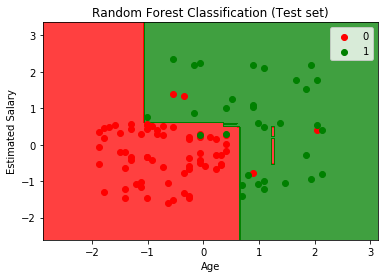

In [6]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

### Visualize the trees

In [7]:
from subprocess import call
from IPython.display import Image
features = list(df.columns[[2,3]])
trees = clf.estimators_
for i in range(0, len(trees)):
    dot = 'tree{}.dot'.format(str(i))
    name = 'tree{}.png'.format(str(i))
    export_graphviz(trees[i], out_file=dot, 
                feature_names = features)
    call(['dot', '-Tpng', dot, '-o', name, '-Gdpi=600'])

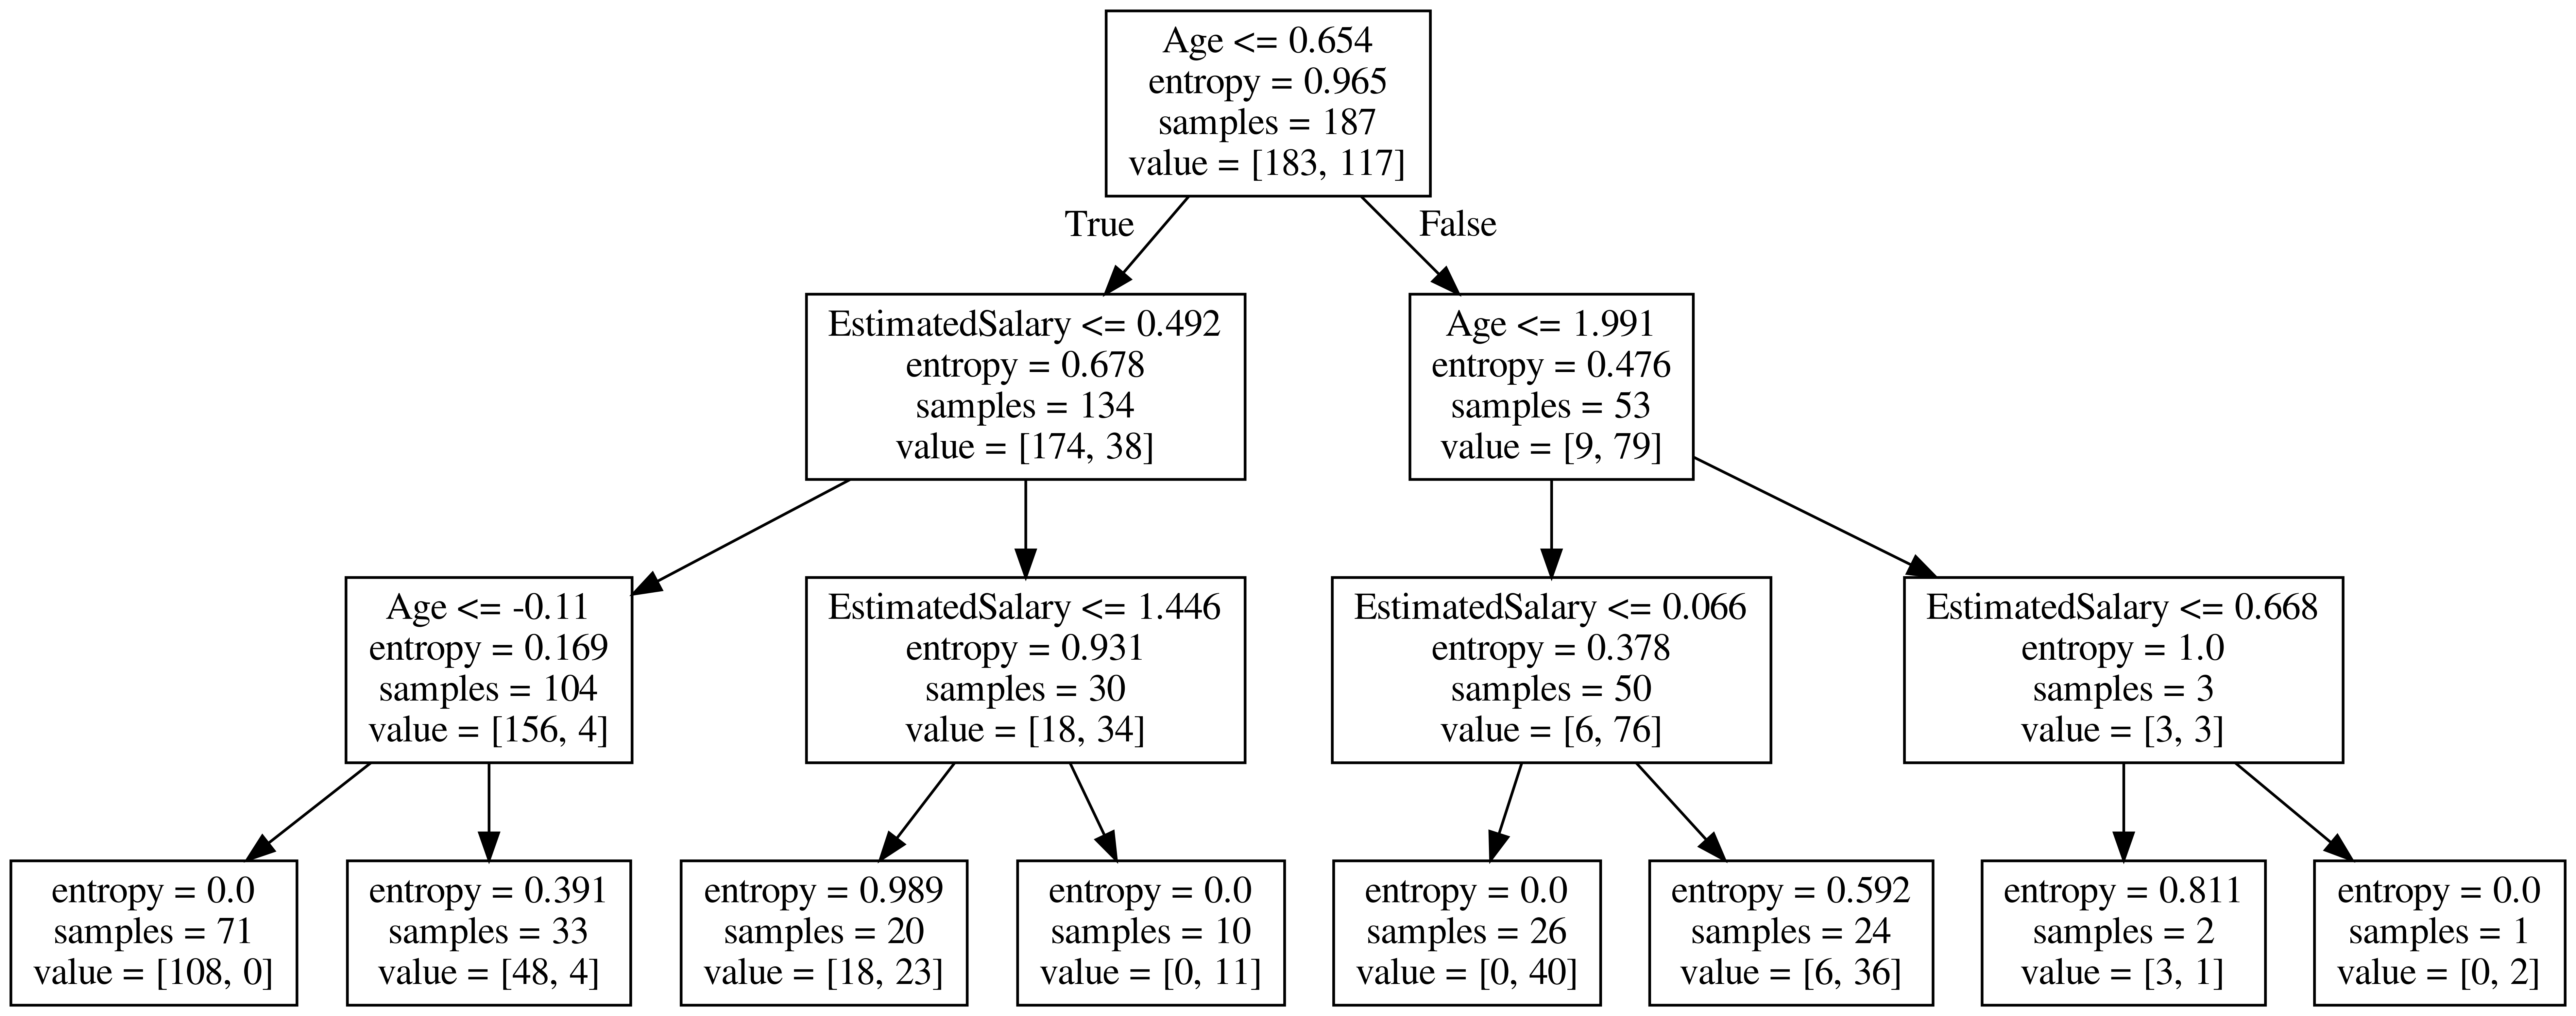

In [8]:
Image(filename = 'tree{}.png'.format(str(0)))

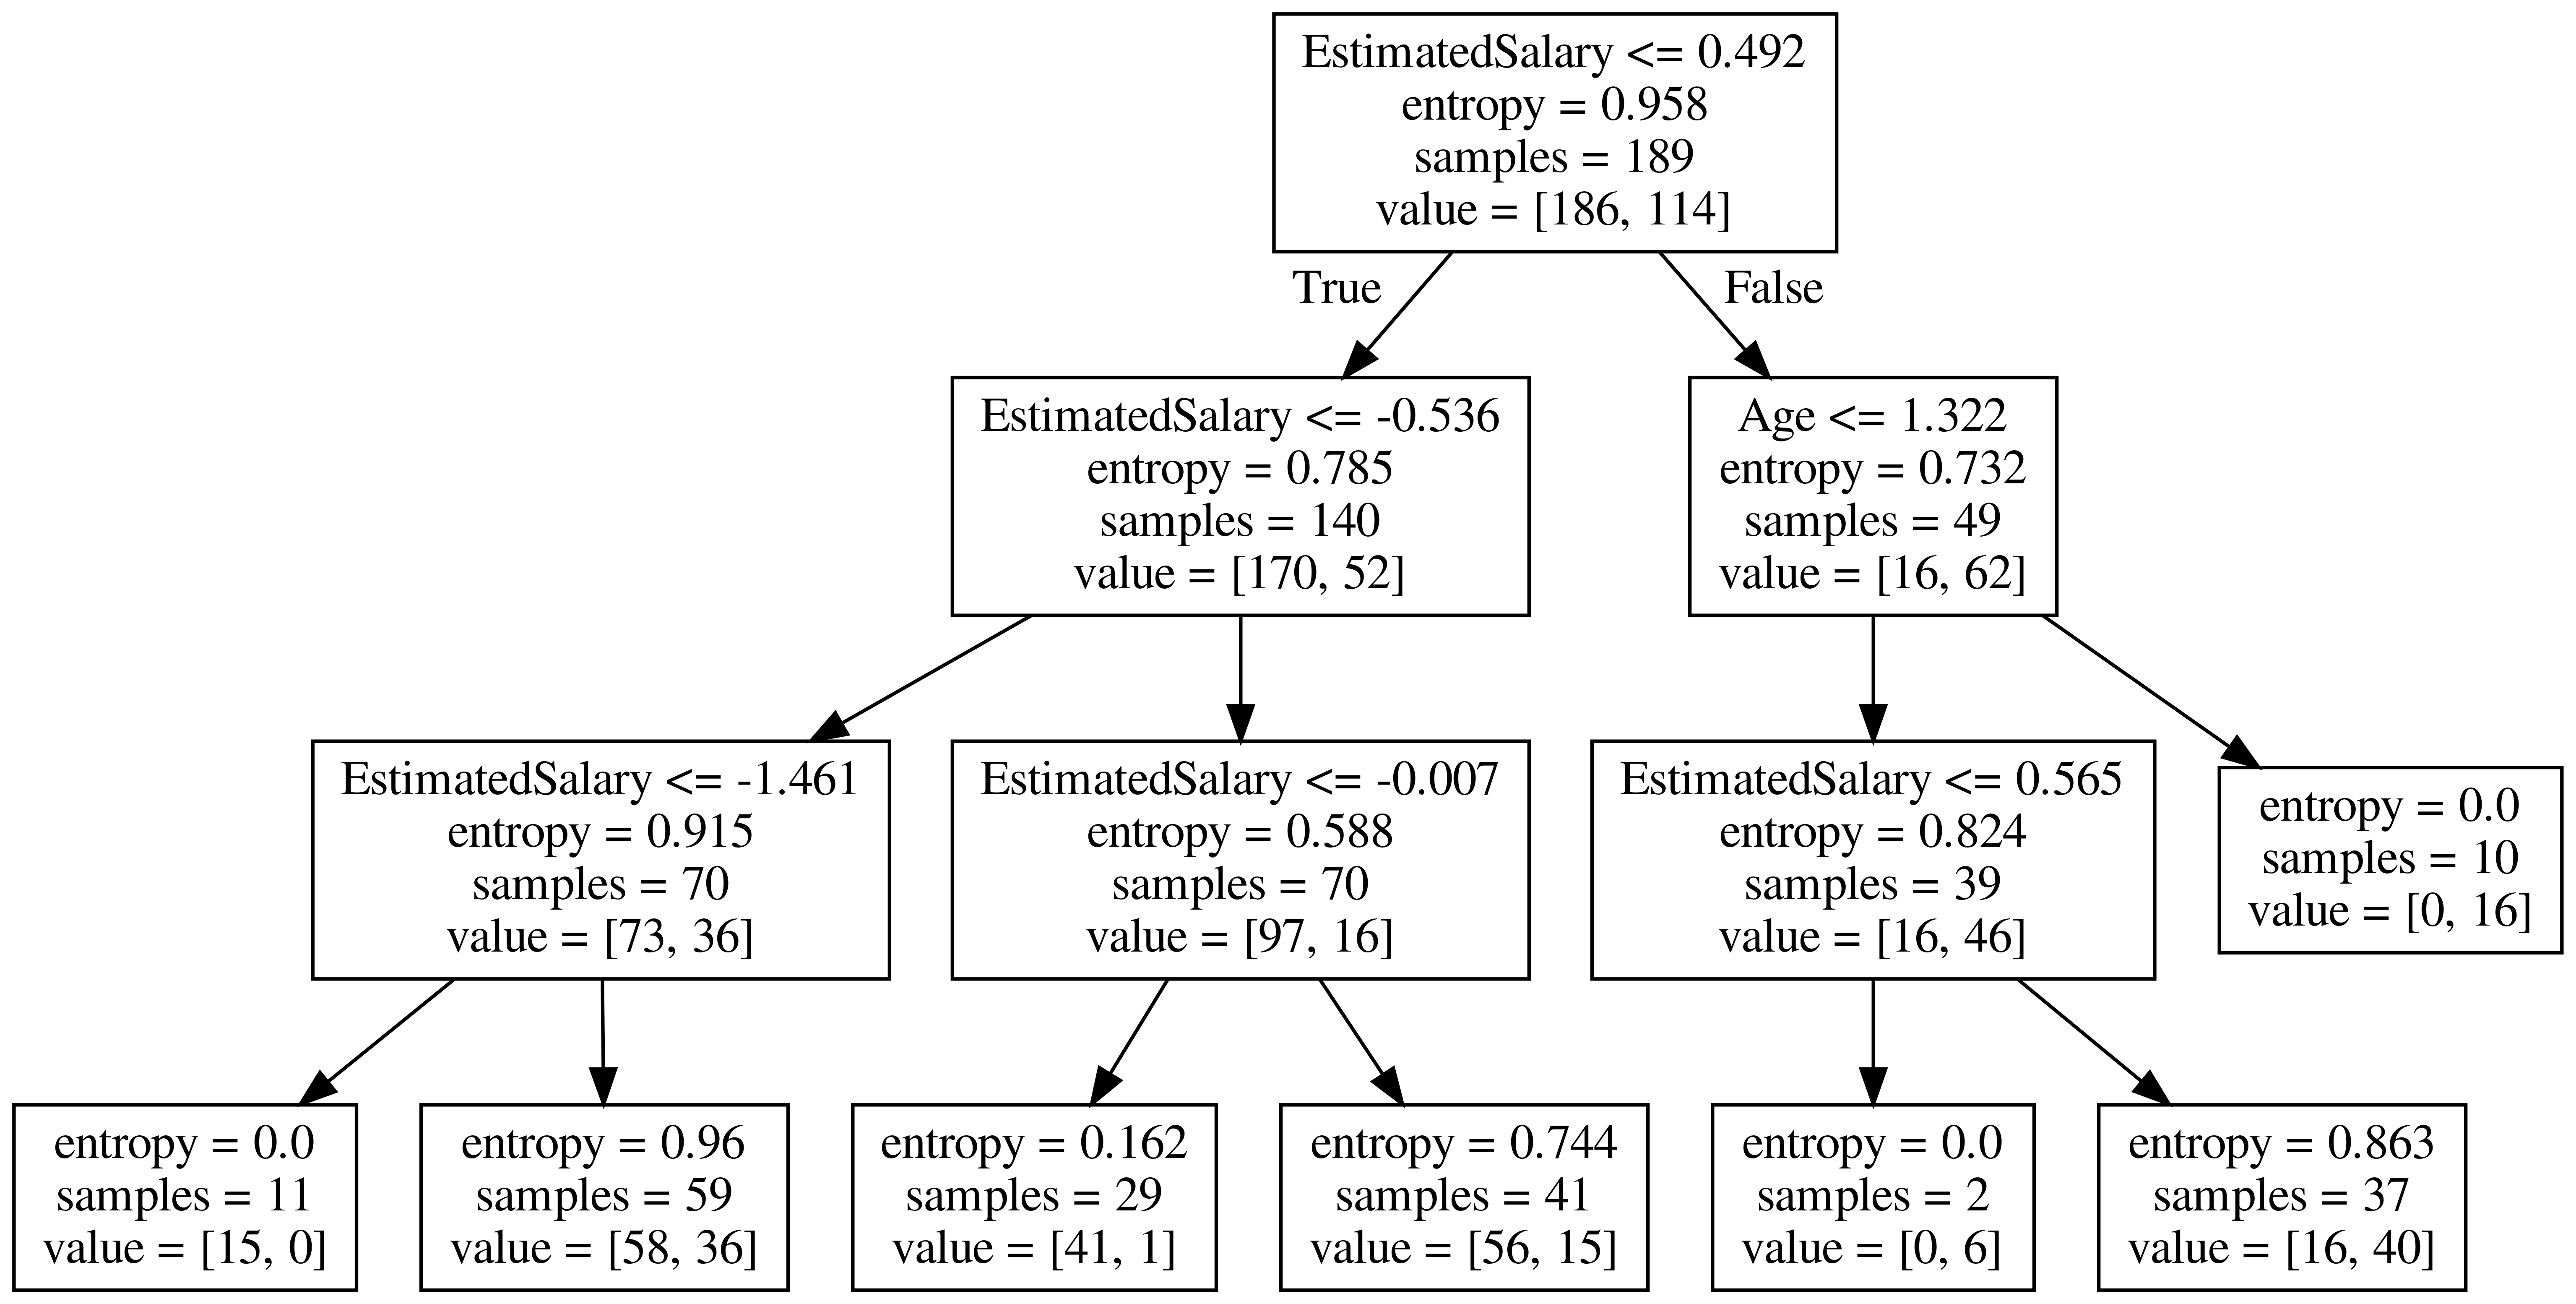

In [9]:
Image(filename = 'tree{}.png'.format(str(1)))

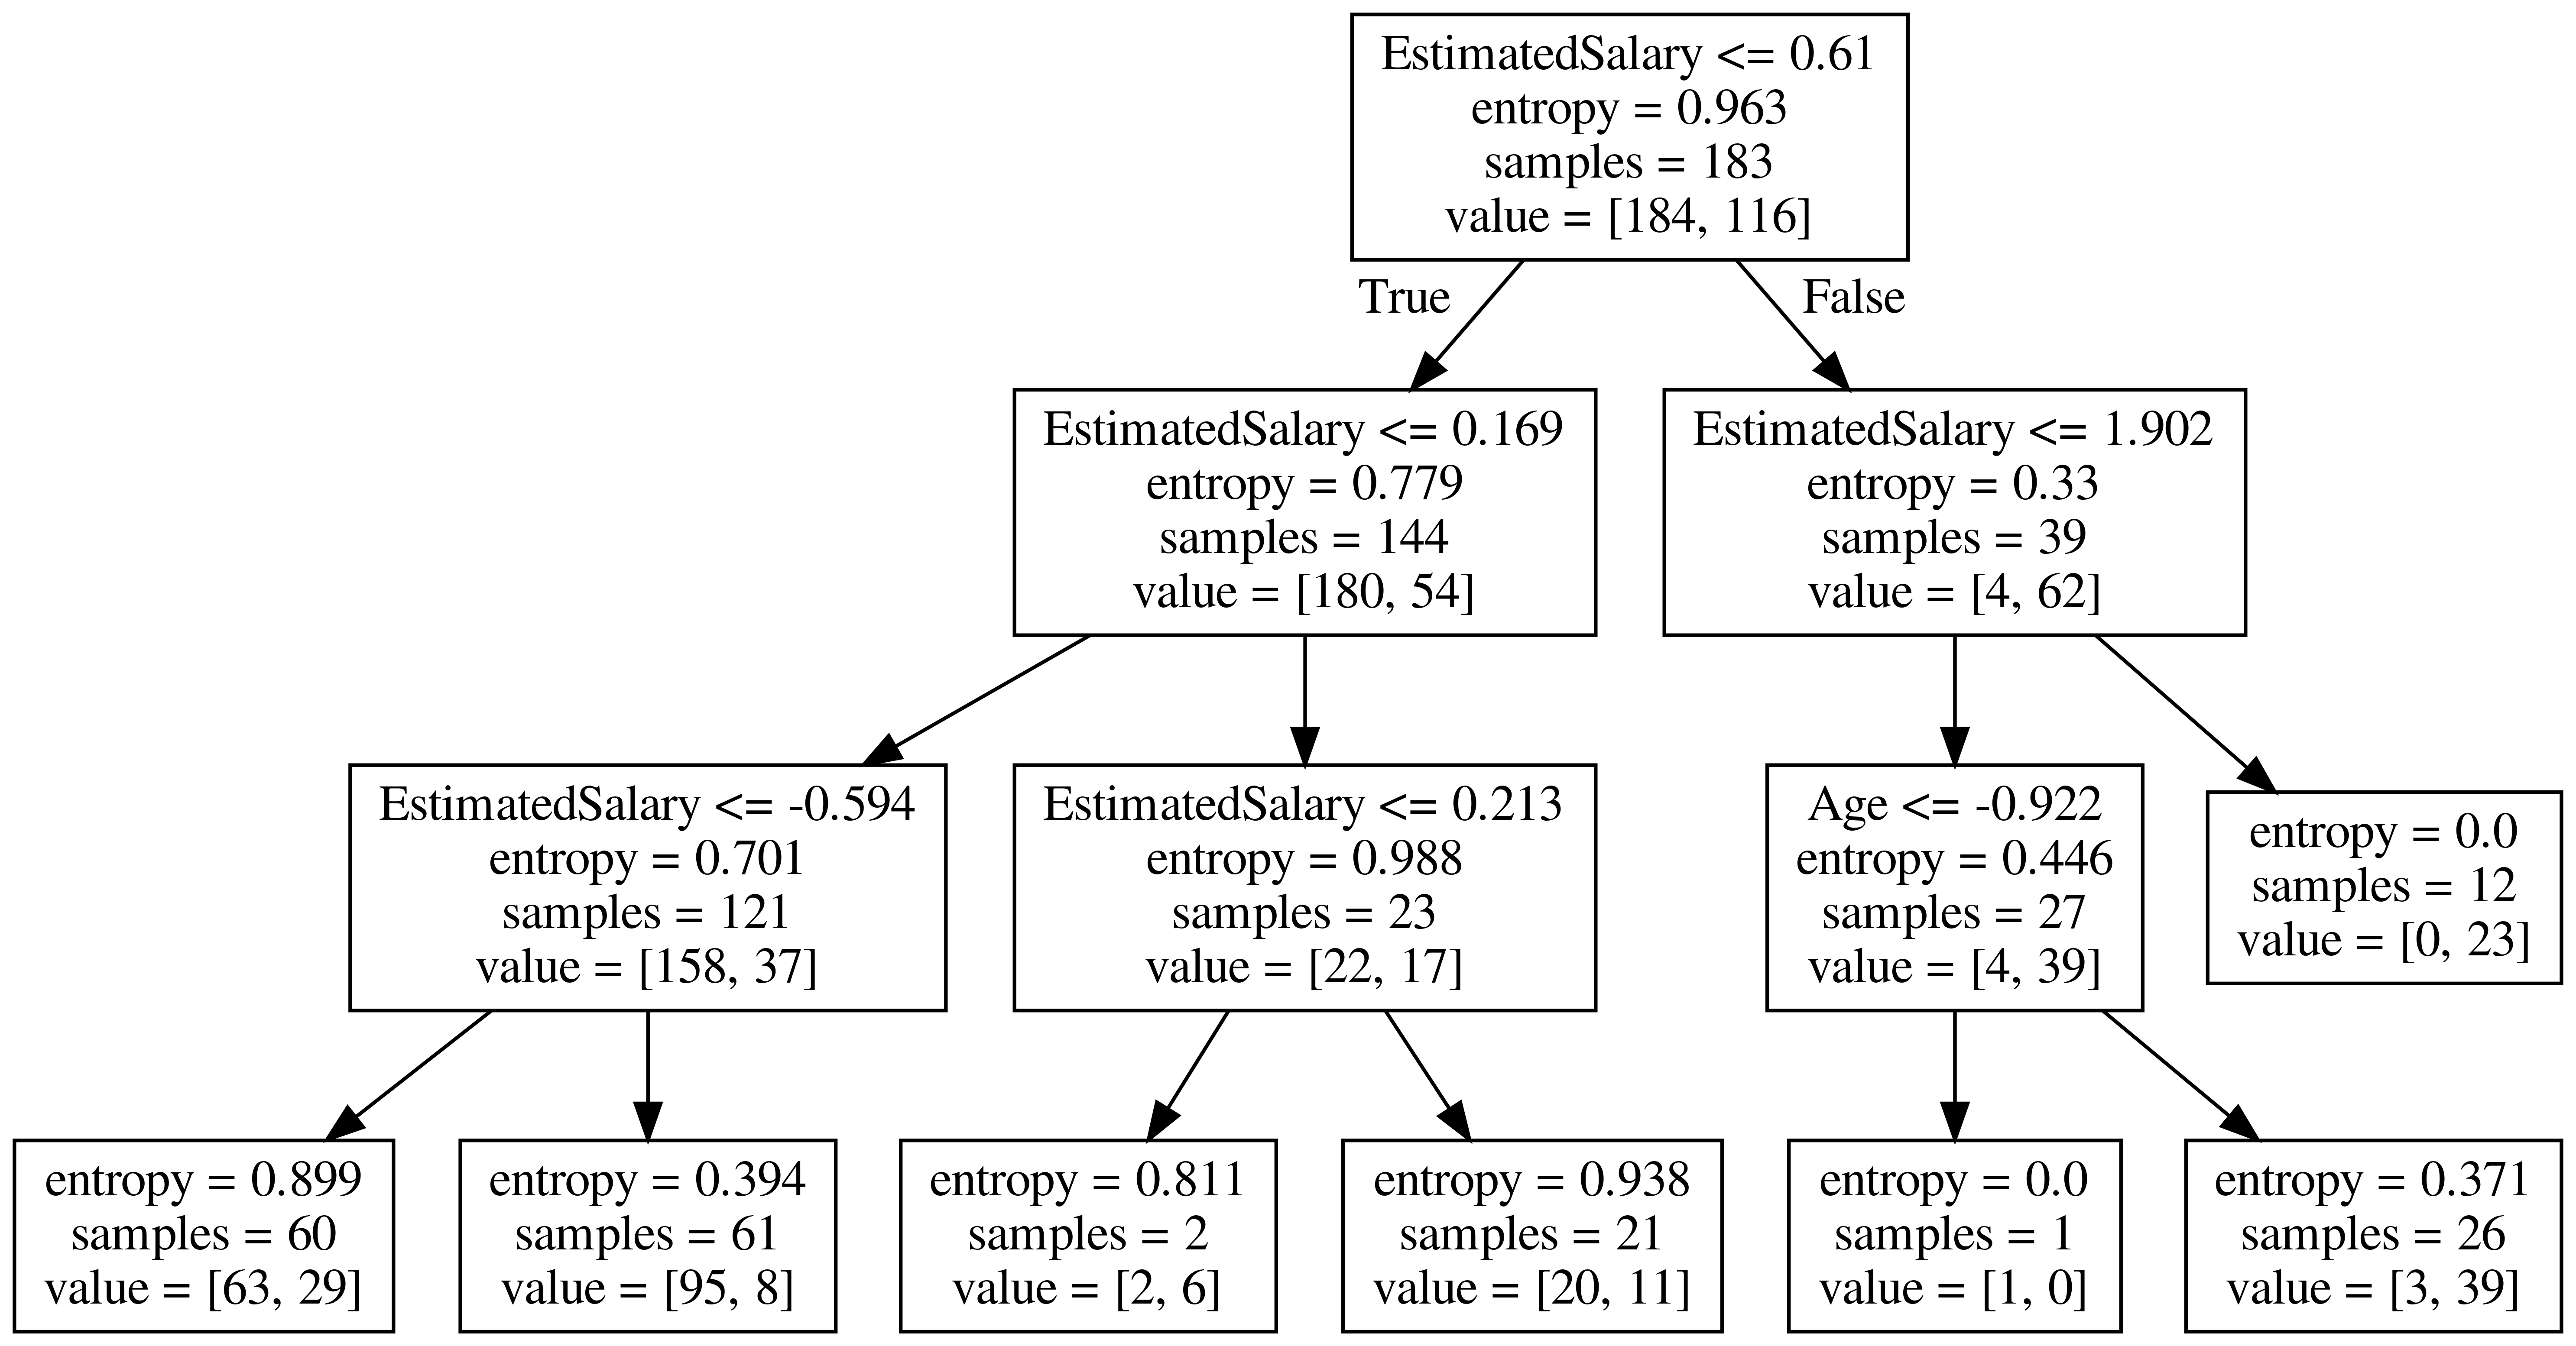

In [10]:
Image(filename = 'tree{}.png'.format(str(2))) #there are more...

### Cumulative accuracy profile 
- https://en.wikipedia.org/wiki/Cumulative_accuracy_profile
- https://medium.com/@lotass/classification-models-performance-evaluation-c3a91562793
- 

In [11]:
from scipy import integrate

def capcurve(y_test, y_pred):
    y_values = y_test
    y_preds_proba = y_pred
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)

    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()

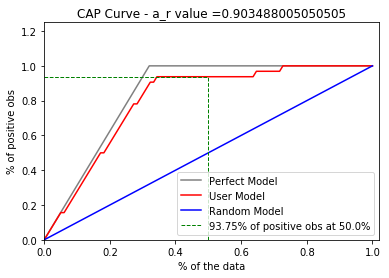

In [12]:
capcurve(y_test, y_pred)

### need to apply k fold cross validation!
- the results seem too good...

In [13]:
clf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=3, random_state=0)
clf.fit(X_train, y_train)
acc2 = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)

- original accuracy

In [16]:
print(acc)

0.94


- most likely accuracy given with k fold cross validation

In [19]:
print(acc2.mean())
print(acc2.std())

0.8938635520949202
0.07023810673993983
